# Self-Organizing Maps

## Importing the libraries

In [1]:
%pip install minisom

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [3]:
dataset = pd.read_csv('dataset/Credit_Card_Applications.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

## Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

## Training the SOM

In [5]:
from minisom import MiniSom
som = MiniSom(x = 12, y = 12, input_len = 15, sigma = 1, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 1000)

## Visualizing the results

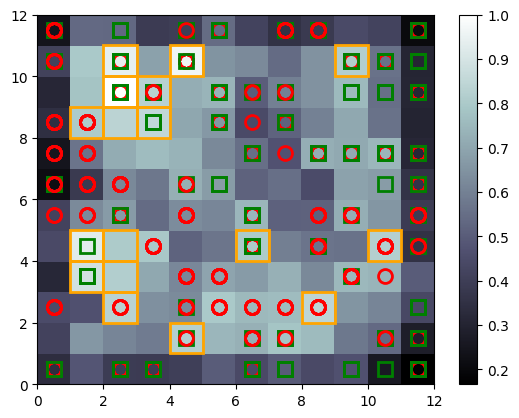

In [6]:
from pylab import bone, pcolor, colorbar, plot, show
from matplotlib.patches import Rectangle
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5, 
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
    
threshold = 0.8
distance_map = som.distance_map()
high_distance_nodes = np.argwhere(distance_map > threshold)

# Get the current axes
ax = plt.gca()

# Add a square border for each high-distance node
for node in high_distance_nodes:
    rect = Rectangle((node[0], node[1]), 1, 1,
                     linewidth=2,
                     edgecolor='orange',
                     facecolor='none')
    ax.add_patch(rect)
    
show()

## Finding the frauds

In [7]:
mappings = som.win_map(X)
frauds = np.concatenate([mappings[tuple(node)] for node in high_distance_nodes if tuple(node) in mappings], axis=0)
frauds = sc.inverse_transform(frauds)
print("Suspected Fraudlent Customer IDs:")
for x, i in enumerate(frauds):
    is_last = (x + 1 == len(frauds))
    is_line_end = (x + 1) % 5 == 0
    end_char = '' if is_last else (',\n' if is_line_end else ', ')
    print('{0:.0f}'.format(frauds[x, 0]), end=end_char)

Suspected Fraudlent Customer IDs:
15654859, 15723827, 15725028, 15731989, 15799785,
15596797, 15600975, 15688210, 15704509, 15592914,
15623668, 15688059, 15646521, 15599152, 15660263,
15615670, 15570990, 15694237, 15692718, 15618703,
15677395, 15583724, 15638610, 15773421, 15682686,
15707602, 15598614, 15712483, 15572361, 15790254,
15768600, 15748552, 15757467, 15801441, 15815443,
15748432, 15788131, 15771856, 15696287, 15808023,
15808386, 15698749, 15764841, 15748649, 15729718,
15786539, 15789611, 15738487, 15781875, 15809837,
15761554, 15811690, 15815095, 15772941, 15759387,
15687688, 15668679, 15649160, 15621244, 15636521,
15632789, 15720725, 15567834, 15591035, 15672912,
15694677, 15608804, 15631267, 15611189, 15698522,
15762799, 15716347, 15642448, 15704581, 15725776,
15697460, 15737998, 15586183, 15718921, 15607988,
15683993, 15797767, 15744044, 15632010, 15804235,
15627365, 15700300, 15791944, 15576680, 15620570,
15592412, 15767358, 15567839, 15642336, 15740487,
15715907, 157683

## Part 2 - Going from Unsupervised to Supervised Deep Learning

### Creating the Matrix of Features

In [8]:
customers = dataset.iloc[:, 1:].values

### Creating the Dependent Variable

In [9]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
  if dataset.iloc[i,0] in frauds:
    is_fraud[i] = 1

## Part 3 - ANN

### Feature Scaling

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

### Building the ANN

In [11]:
import tensorflow as tf
tf.__version__

'2.19.0'

In [23]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=20, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training the ANN

In [24]:
ann.fit(customers, is_fraud, batch_size = 1, epochs = 4)

Epoch 1/4
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.8300 - loss: 0.4704
Epoch 2/4
690/690 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.8427 - loss: 0.3342
Epoch 3/4
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - accuracy: 0.8578 - loss: 0.3008
Epoch 4/4
690/690 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.8791 - loss: 0.2644


### Predicting the test set results

In [25]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [22]:
print(y_pred)

[[1.57901130e+07 2.78571574e-03]
 [1.56305920e+07 8.57672654e-03]
 [1.57535910e+07 1.03128022e-02]
 ...
 [1.58150400e+07 6.39430523e-01]
 [1.56472950e+07 6.50420666e-01]
 [1.57257760e+07 6.60762191e-01]]
